# Лабораторная работа "Фемптосекундный  лазер"

## В  настоящем блокноте представлена  программа для  выполнения следующих задач:<br>
### 1)Определяете период следования и частоту повторений импульсов лазера  
### 2)Определяете время наростания фронта импульсов от 10% до 90% на обоих фотоприёмниках
### 3)Привести спектр и описать его, определить ширину спектра 
### 4)Привести среднюю мощность на выходе из лазера и кристалла, определить эффективность преобразования во 2 гармонику 
### 5)Проверить, является ли импульс спектрально ограниченным
### 6)Оценить энергию в одном импульсе
### 7)Посчитать пиковую мощность 
### 8)Посчитать пиковую интенсивность при фокусировке импульса в пятно диаметром 8 мкм

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.signal import argrelextrema
from scipy.signal import find_peaks, peak_widths,savgol_filter
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
import copy
import math
from scipy.stats import t

In [2]:
data_path =  "femtosecond_laser_lab_data"
save_path = "results"

In [3]:
c = 3*10**8 # скорость света

In [4]:
def unpack(path,name,delimiter):
    data = np. loadtxt(path + "\\" + name, dtype='float',delimiter=delimiter)
    return data[:,0], data[:,1]

def calc_vlines_params(max_ind, time, max_level,  start=None):
    vlines_param = []
    peak = len(max_ind)
    for i in range(peak):
        if i == 0: 
            y_max = max([max_level[i], max_level[i + 1]]) + max_level.max() * 0.075
        elif i < peak - 1: 
            y_max = max([max_level[i - 1], max_level[i], max_level[i + 1]]) + max_level.max() * 0.1
        else:
            y_max = max([ max_level[-1], max_level[-2]]) + max_level.max() * 0.075
        if start is None:
            y_min = max_level[i]
        else:
            y_min = start
        time_coord = time[max_ind[i]]
        vlines_param.append([time_coord, y_min, y_max])
    return vlines_param

def calc_arrow_params_2(max_ind, time, max_level, arrow_head_procent, tau_step):
    arrow_params = []
    for i in range(len(max_ind ) - 1):
        arrow_high = max([max_level[i], max_level[i + 1]]) + max_level.max()  * 0.05
        arrow_center =(time[max_ind[i + 1]] + time[max_ind[i]]) / 2
        arrow_length =  (time[max_ind[i + 1]] - time[max_ind[i]]) * (arrow_head_procent - 1) / 2 
        arrow_head_length = (time[max_ind[i + 1]] - time[max_ind[i]]) * (arrow_head_procent) / 2 
        tau_time = time[max_ind[i]] + (arrow_center - time[max_ind[i]]) * tau_step 
        tau_high = max([max_level[i], max_level[i + 1]]) + max_level.max()   * 0.07
        arrow_params.append([arrow_center, arrow_high, arrow_length, arrow_head_length, tau_time, tau_high ])
    return arrow_params


def find_max(data, prominence, distance):
    max_ind = find_peaks(data[1],  prominence =  prominence, distance = distance)
    return [data[0][max_ind[0]],data[1][max_ind[0]], max_ind[0]]

def rand_error(data, conf_prob):
    mean = np.mean(data)
    n = len(data)
    #Доверительная вероятность  
    #conf_prob = 0.66 
    student_coef = round(t.ppf((1 + conf_prob )/2, n - 1), 2)
    var = np.var(data)
    interval = student_coef * math.sqrt((var)/n)
    return [mean, interval]
 
def round_func(errors):
    r_errors = []
    for error in errors: 
        r_error = np.round(error, -int(math.floor(math.log10(abs(error)))))
        power = np.log10(abs(r_error))
        if r_error * 10**abs(power) == 1:
            r_error = round(error, 2-int(math.floor(math.log10(abs(error))))-1)
        r_errors.append(r_error)
    return r_errors

def get_nearest_value(n_value, array):
    result_index = np.argmin(abs(array-n_value))
    return  result_index, array[result_index]

Перед обработкой данных лучше удалить в файлах первые строки с настройками и оставить только координаты

In [5]:
oscill_settings = ["LECROYWR44Xi, 19495, Waveform", 
                    "Segments,1,SegmentSize, 1000001",
                    "Segment,TrigTime,TimeSinceSegment1"
                    "1,05-Apr-2022 06:39:46,0"                 
                    "Time, Ampl"]

spectrometer_settings = ["Source: Spectrum Viewer"
                         "Chart: Pulse Spectrum"
                         "Series:" 
                         "Wavelength (nm)	S (a.u.)"]

In [6]:
name = ["period.txt", "rise_first_detector.txt", "rise_second_detector.txt","spectrum.dat"]

In [7]:
time, signal  =  unpack(data_path, "period.txt",delimiter=',')  #без фильтрации 
period_time, period_signal = unpack(data_path, "period.txt",delimiter=',') 
period_time = period_time - period_time[0] #сдвинем на 0

## 1)Определяете период следования и частоту повторений импульсов лазера 

In [8]:
#фильтрация
period_signal = savgol_filter(period_signal, 99, 3)

In [9]:
#prominence необходимо настроить для так, чтобы количество видимых на графике пиков сопадало с тем, что выдаёт функция 
max_period_time, max_period_signal, max_period_ind = find_max([period_time,period_signal], prominence=0.5, distance=300)

In [10]:
#расстояние между пиками 
interval_period = np.diff(max_period_time)

In [11]:
#среднее и погрешности 
#eps -относительная погрешность осциллографа
eps = 0.0005
mean_interval_period, Delta_rand_mean_interval_period = rand_error(interval_period, conf_prob=0.99)
Delta_mean_interval_period = math.sqrt(Delta_rand_mean_interval_period**2 + (mean_interval_period*eps)**2)
delta_mean_interval_period = Delta_mean_interval_period / mean_interval_period
print("Период следования импульсов лазера в с", mean_interval_period)
print("Абсолютная погрешность = ", round_func([Delta_mean_interval_period])[0])
print("Относительна погрешность = ", round_func([delta_mean_interval_period])[0],"\n")

Период следования импульсов лазера в с 0.000499154
Абсолютная погрешность =  3e-07
Относительна погрешность =  0.0005 



$Т_{pulse}~=~(4992\pm3)*10^-7~c~~~\delta{T} = 0.05\% $

Период следования импульсов лазера в Гц(Частотный интервал).

In [12]:
freq_interval_period = 1 / mean_interval_period
Delta_interval_period = freq_interval_period * delta_mean_interval_period
delta_interval_period = delta_mean_interval_period
print("Период следования импульсов лазера в с", freq_interval_period)
print("Абсолютная погрешность = ", round_func([Delta_interval_period])[0])
print("Относительна погрешность = ", round_func([delta_interval_period])[0],"\n")

Период следования импульсов лазера в с 2003.3897354323515
Абсолютная погрешность =  1.0
Относительна погрешность =  0.0005 



$\nu_{pulse}~=~(2003\pm1)~~Гц~~~~\delta{\nu}~=~0.05$%

In [13]:
time_coef = 1e+3
ampl_coef = 1
# проведём стрелку только между центральными пиками 
central_peaks_ind = int(len(max_period_ind)/2)
arrow_head_width = 8e-3
vlines = calc_vlines_params(
                            max_ind=max_period_ind[central_peaks_ind-1:central_peaks_ind+1],
                            time=period_time,
                            max_level=max_period_signal[central_peaks_ind-1:central_peaks_ind+1],  
                            start=None
                           )
arrow = calc_arrow_params_2(max_ind=max_period_ind[central_peaks_ind-1:central_peaks_ind+1],
                            time=period_time,
                            max_level=max_period_signal[central_peaks_ind-1:central_peaks_ind+1], 
                            arrow_head_procent=0.1,
                            tau_step=0.4)

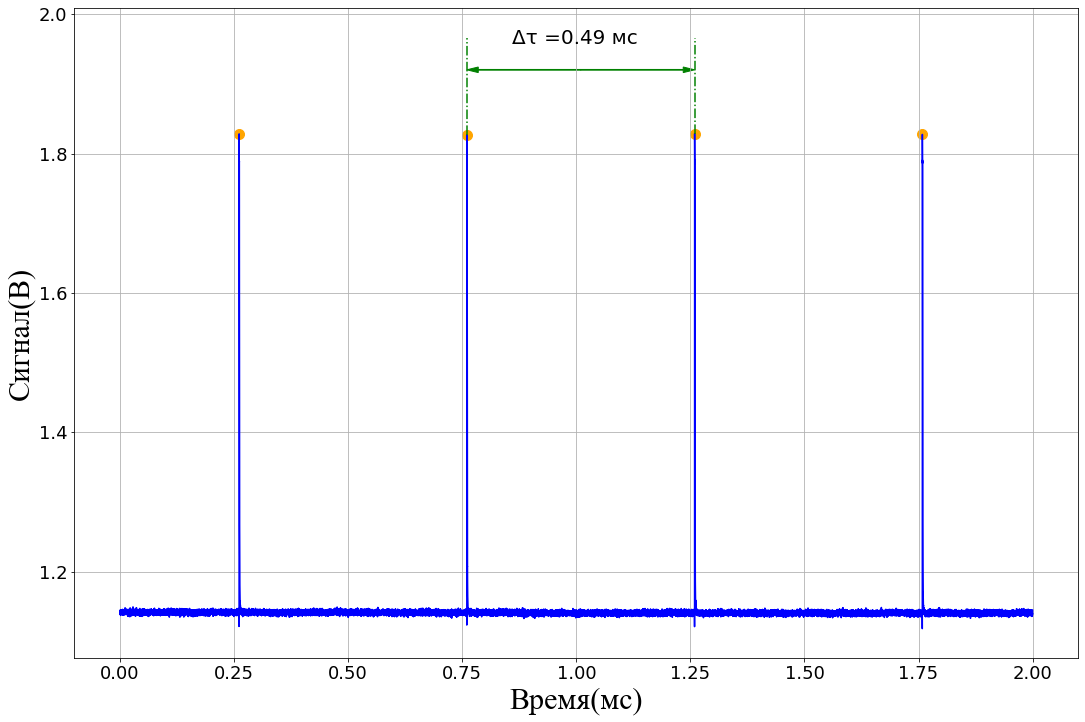

In [14]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(period_time * time_coef, period_signal*ampl_coef, c = 'blue') 
ax.set_xlabel('Время(мс)',{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=30)
ax.set_ylabel("Сигнал(В)",{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=30)

for i in range(len(max_period_ind)):
    ax.scatter(max_period_time[i]*time_coef, max_period_signal[i]*ampl_coef, color='orange', s=100, marker='o')
    
for i in range(2):
    ax.vlines(vlines[i][0] * time_coef, ymin = vlines[i][1] * ampl_coef, 
              ymax = vlines[i][2] * ampl_coef, color = 'green', linestyles = 'dashdot'
              )
    
ax.arrow(
          arrow[0][0] * time_coef,  arrow[0][1] * ampl_coef, + arrow[0][2] * time_coef, 0,
          head_width=arrow_head_width * ampl_coef, head_length=arrow[0][3] * time_coef, color = 'g'
            )
ax.arrow(
          arrow[0][0] * time_coef,  arrow[0][1] * ampl_coef, -arrow[0][2] * time_coef, 0,
          head_width=arrow_head_width * ampl_coef, head_length=arrow[0][3] * time_coef, color = 'g'
            )

ax.text(arrow[0][4] * time_coef,arrow[0][5] * ampl_coef, "Δτ =0.49 мс ".format(str(i)), fontsize = 20)
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=18)
ax.grid()
#plt.savefig(save_path + "\\" + "full_periods_graph.jpg")

Рассмотрим случай без фильтрации.
График без фильтрации

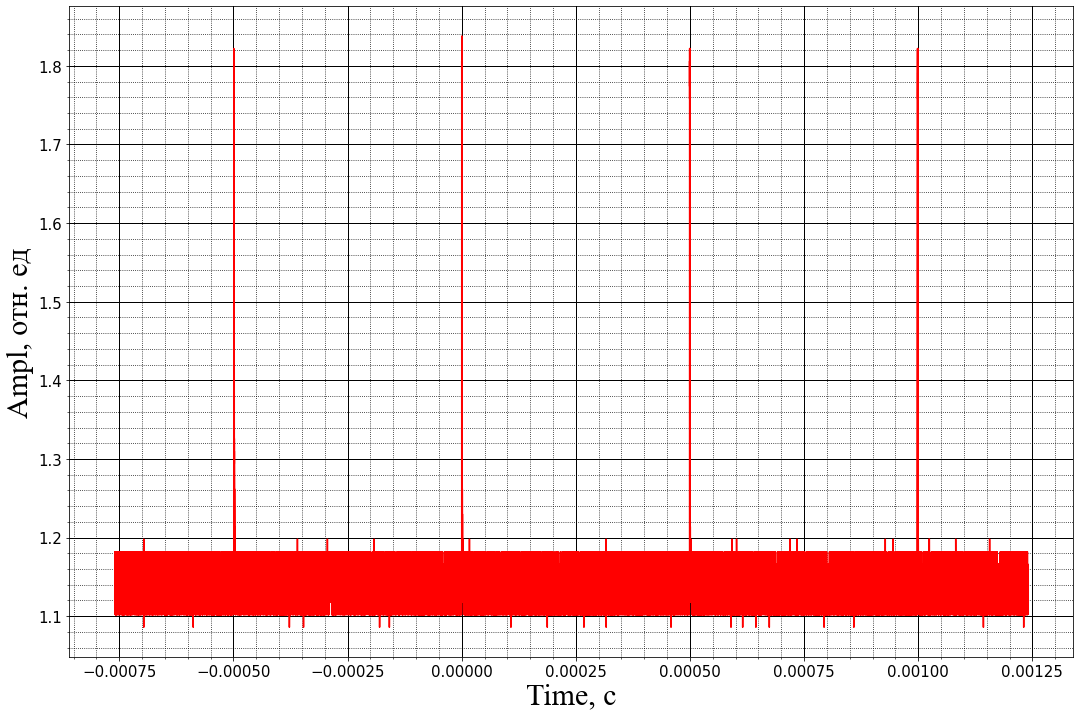

In [15]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(time,  signal, c = 'r') 
ax.set_xlabel('Time, c',{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=30)
ax.set_ylabel("Ampl, отн. ед",{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=30)
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=15)
ax.minorticks_on()

#  Определяем внешний вид линий основной сетки:
ax.grid(which='major',
        color = 'k', 
        linewidth = 1)

#  Определяем внешний вид линий вспомогательной
#  сетки:
ax.grid(which='minor', 
        color = 'k', 
        linestyle = ':')

## Определим время нарастания фронта импульсов от 10% до 90% на первом фотоприёмнике

In [16]:
f_detect_time,f_detect_signal = unpack(data_path, "rise_first_detector.txt", delimiter=',')
#сдвинем на 0
f_detect_time = f_detect_time - f_detect_time[0]
f_detect_signal = f_detect_signal - f_detect_signal.min()

In [17]:
#фильтрация
f_detect_signal = savgol_filter(f_detect_signal, 21, 3)

Будем считать максимумом усреднённое значение точек после фронта, поэтому нужно самостоятельно подоюрать индекс, с которого начинать расчёт среднего в нашем случае это 250

In [18]:
max_f_detect_signal = np.mean(f_detect_signal[250:])

In [19]:
#получим значение на 90% 
shift = 160
f_detect_signal_09_ind, f_detect_signal_09 = get_nearest_value(0.9 * max_f_detect_signal, f_detect_signal[shift:])
#сдвинутына 100, поэтому их нужно вернуть назад 
f_detect_signal_09_ind = f_detect_signal_09_ind+shift
f_detect_time_09 = f_detect_time[f_detect_signal_09_ind]

In [20]:
#получим значение на 10% 
f_detect_signal_01_ind, f_detect_signal_01 = get_nearest_value(0.1 * max_f_detect_signal, f_detect_signal[shift:])
#сдвинутына 100, поэтому их нужно вернуть назад 
f_detect_signal_01_ind = f_detect_signal_01_ind+shift
f_detect_time_01 = f_detect_time[f_detect_signal_01_ind]

Вышеуказанные ячейку не всегда могут корректно отработать, потому что может встретиться шум, который будет к уровням ближе, чем точки на фронте, поэтому лучше сразу выделять область, на которой только фронт и там уже пользоваться этими ячейками

Вычислим время нарастания фронта

In [21]:
rise_f_detect = f_detect_time_09 - f_detect_time_01
Delta_rise_f_detect = eps *rise_f_detect
delta_rise_f_detect = eps
print("Время нарастания импульса = ", rise_f_detect)
print("Абсолютная погрешность = ", round_func([Delta_rise_f_detect])[0])
print("Относительна погрешность = ", round_func([delta_rise_f_detect])[0],"\n")

Время нарастания импульса =  2.9999990000000034e-09
Абсолютная погрешность =  1.5e-12
Относительна погрешность =  0.0005 



$t_{rise_1}~=~(3000\pm2)*10^{-12}~c~~~\delta{t_{rise_1}}$ = 0.05$%

Соответсвующая полоса пропускания определяется из формулы $S~=~0.35/t_{rise1}$

In [22]:
S1 = 0.35/rise_f_detect
Delta_S1 = 0.35/rise_f_detect*delta_rise_f_detect
delta_S1 = delta_rise_f_detect
print(S1, Delta_S1, delta_S1)

116666705.55556838 58333.352777784195 0.0005


$S_{1}~=~(11667\pm6)*10^4~Гц~~~~~\delta{S_{1}}~=~5$%

In [23]:
time_coef = 1e+9
ampl_coef = 1

vlines = calc_vlines_params(
                            max_ind=np.array([f_detect_signal_01_ind, f_detect_signal_09_ind]),
                            time=f_detect_time,
                            max_level=np.array([max_f_detect_signal, max_f_detect_signal]),  
                            start=0
                           )
arrow = calc_arrow_params_2(max_ind=np.array([f_detect_signal_01_ind, f_detect_signal_09_ind]),
                            time=f_detect_time,
                            max_level=np.array([max_f_detect_signal, max_f_detect_signal]), 
                            arrow_head_procent=0.2,
                            tau_step=0.1)

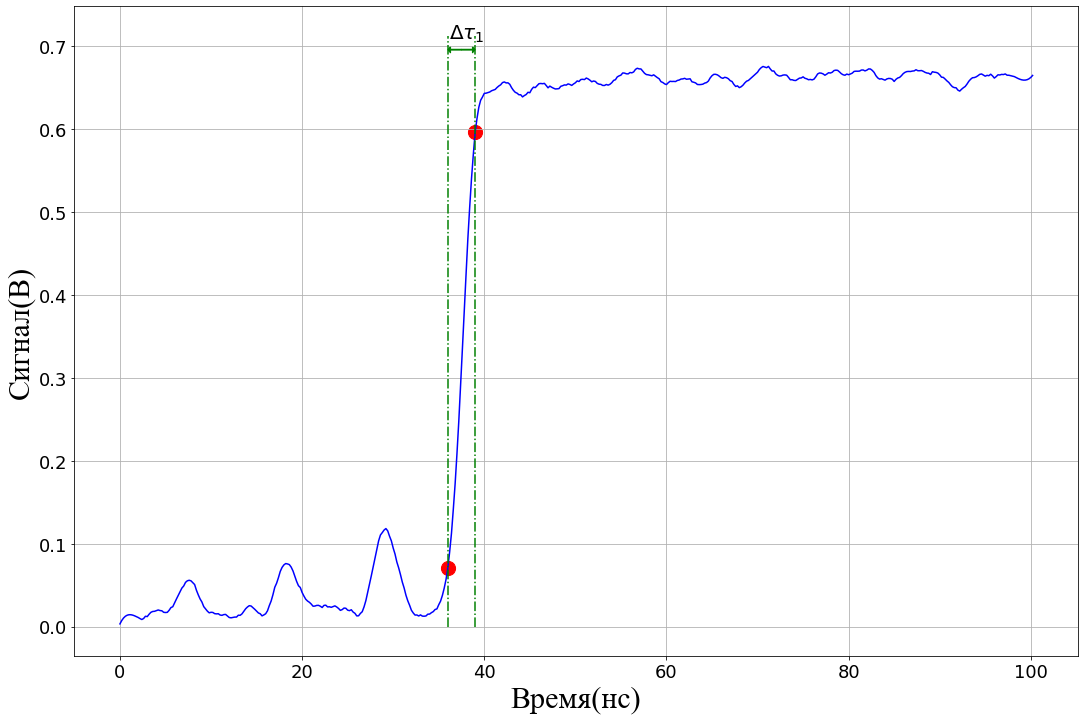

In [24]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(f_detect_time * time_coef, f_detect_signal * ampl_coef, c = 'blue') 
ax.set_xlabel('Время(нс)',{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=30)
ax.set_ylabel("Сигнал(В)",{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=30)

for i in range(2):
    ax.vlines(vlines[i][0] * time_coef, ymin = vlines[i][1] * ampl_coef, 
              ymax = vlines[i][2] * ampl_coef, color = 'green', linestyles = 'dashdot'
             )
ax.arrow(
          arrow[0][0] * time_coef,  arrow[0][1] * ampl_coef, + arrow[0][2] * time_coef, 0,
          head_width=arrow_head_width * ampl_coef, head_length=arrow[0][3] * time_coef, color = 'g'
            )
ax.arrow(
          arrow[0][0] * time_coef,  arrow[0][1] * ampl_coef, -arrow[0][2] * time_coef, 0,
          head_width=arrow_head_width * ampl_coef, head_length=arrow[0][3] * time_coef, color = 'g'
            )

ax.scatter(f_detect_time_01*time_coef, f_detect_signal_01*ampl_coef, color='r', s=200, marker='o')
ax.scatter(f_detect_time_09*time_coef, f_detect_signal_09*ampl_coef, color='r', s=200, marker='o')

ax.text(arrow[0][4] * time_coef,arrow[0][5] * ampl_coef, "$Δτ_{1}$ ", fontsize = 20)
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=18)
ax.grid()
plt.savefig(save_path + "\\" + "rise_first_detector.jpg")

## Определим время нарастания фронта импульсов от 10% до 90% на втором фотоприёмнике

In [25]:
s_detect_time,s_detect_signal = unpack(data_path, "rise_second_detector.txt", delimiter=',')
#сдвинем на 0
s_detect_time = s_detect_time - s_detect_time[0]
s_detect_signal = s_detect_signal - s_detect_signal.min()

У этого приёмника весьма маленькое время релаксации, поэтому найти максимум, усреднив последние точки, не получится

prominence нужно подобрать так, чтобы функция давала только один пик

In [26]:
max_s_detect_time, max_s_detect_signal, max_s_detect_ind = find_max(
                                                                    [s_detect_time,s_detect_signal], 
                                                                    prominence=0.01,
                                                                    distance=10)

Из-за малого количества точек, время нарастания фронта придется определять вручную, однако на графике все обозначения будут выставлены на правильных уровнях, кроме того, погрешность тоже определим по-другому 

In [48]:
rise_s_detect = max_s_detect_time - s_detect_time[max_s_detect_ind-2]
Delta_rise_s_detect = math.sqrt(((s_detect_time[1]-s_detect_time[0])/2)**2 +  (eps *rise_s_detect)**2 )
delta_rise_s_detect = Delta_rise_s_detect / rise_s_detect
print("Время нарастания импульса = ", rise_s_detect)
print("Абсолютная погрешность = ", Delta_rise_s_detect)
print("Относительна погрешность = ", delta_rise_s_detect,"\n")
print(s_detect_time[1]-s_detect_time[0])

Время нарастания импульса =  [4.e-10]
Абсолютная погрешность =  1.0000019999980007e-10
Относительна погрешность =  [0.2500005] 

2.0000000000000014e-10


$t_{rise_2}~=~(0.4\pm 0.11)~нc~~~\delta{t_{rise_2}}$ = 0.25$%

Соответсвующая полоса пропускания

In [28]:
S2 = 0.35/rise_s_detect
Delta_S2 = 0.35/rise_s_detect*delta_rise_s_detect
delta_S2 = delta_rise_s_detect
print(S2, Delta_S2, delta_S2)

[8.75e+08] [437500.] [0.0005]


$S_{2}~=~(8750\pm4)*10^5~Гц~~~~~\delta{S_{2}}~=~5$%

График тоже придётся строить в полуручном режиме

In [29]:
time_coef = 1e+9
ampl_coef = 1e+3
level_01 = 0.1 * max_s_detect_signal 
level_09 = 0.9 * max_s_detect_signal
arrow_head_width = 5e-4
arrow_width = 1e-4
arrow_center = (
                ((s_detect_time[max_s_detect_ind-1]+0.15e-9) + (s_detect_time[max_s_detect_ind-2]-0.11e-9))/2
                )[0]
arrow_high = 1.05* max_s_detect_signal[0]
arrow_length = (((s_detect_time[max_s_detect_ind-1]+0.15e-9) - (s_detect_time[max_s_detect_ind-2]-0.11e-9))/2*0.8)[0]
arrow_head_length = (0.2*(((s_detect_time[max_s_detect_ind-1]+0.15e-9) - (s_detect_time[max_s_detect_ind-2]-0.11e-9))/2))[0]

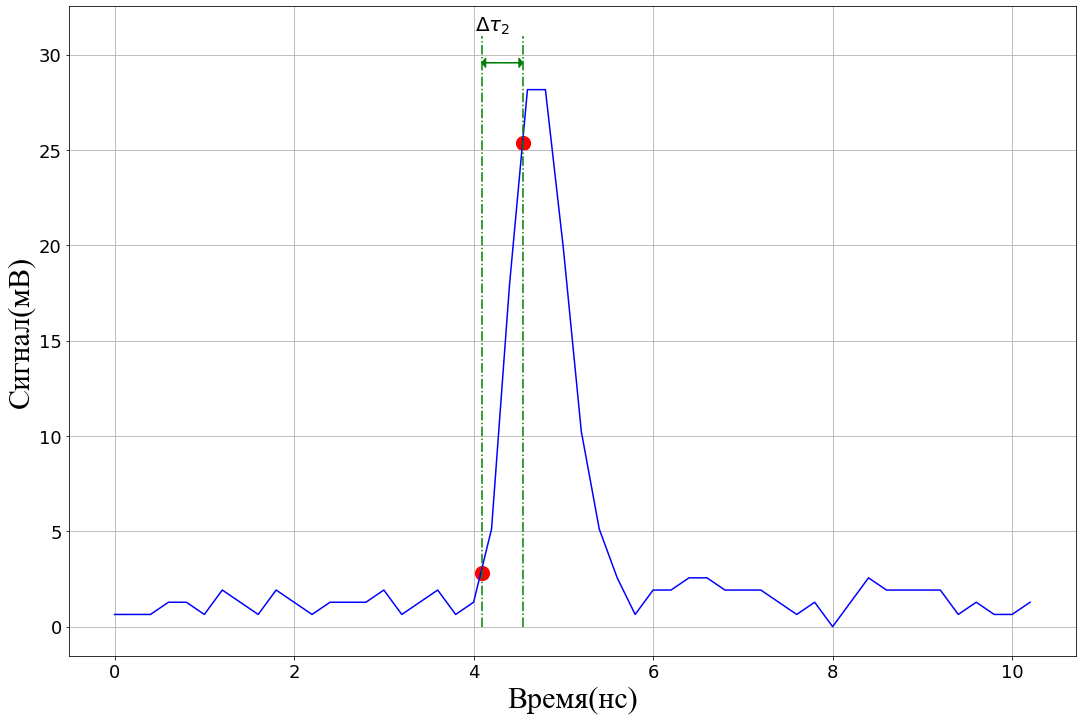

In [30]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(s_detect_time * time_coef, s_detect_signal * ampl_coef, c = 'blue') 
ax.set_xlabel('Время(нс)',{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=30)
ax.set_ylabel("Сигнал(мВ)",{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=30)
ax.vlines((s_detect_time[max_s_detect_ind-1]+0.15e-9) * time_coef, ymin = 0, 
          ymax =max_s_detect_signal *1.1* ampl_coef, color = 'green', linestyles = 'dashdot'
             )
ax.vlines((s_detect_time[max_s_detect_ind-2]-0.11e-9) * time_coef, ymin = 0, 
          ymax =max_s_detect_signal *1.1* ampl_coef, color = 'green', linestyles = 'dashdot'
             )

ax.arrow(
          arrow_center * time_coef,  arrow_high * ampl_coef, + arrow_length * time_coef, 0,
          head_width=arrow_head_width * ampl_coef, head_length=arrow_head_length * time_coef, color = 'g',width = arrow_width
            )
ax.arrow(
          arrow_center * time_coef,  arrow_high * ampl_coef, -arrow_length * time_coef, 0,
          head_width=arrow_head_width * ampl_coef, head_length=arrow_head_length * time_coef, color = 'g',width = arrow_width
            )

ax.scatter((s_detect_time[max_s_detect_ind-1]+0.15e-9)*time_coef, level_09*ampl_coef, color='r', s=200, marker='o')
ax.scatter((s_detect_time[max_s_detect_ind-2]-0.11e-9)*time_coef, level_01*ampl_coef, color='r', s=200, marker='o')

# ax.text(arrow[0][4] * time_coef,arrow[0][5] * ampl_coef, "$Δτ_{first}$ ", fontsize = 20)
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=18)
ax.text((arrow_center-0.30e-9)*time_coef,  max_s_detect_signal*1.11 * ampl_coef, "$Δτ_{2}$ ", fontsize = 20)
ax.grid()
plt.savefig(save_path + "\\" + "rise_second_detector.jpg")

# Третье задание 
## Измерение спектра по спектрометру

In [31]:
wavelenght, Signal_spectrum  = unpack(data_path, "spectrum.DAT",delimiter='\t') 
print(wavelenght[47:57])

[962.945 962.986 963.027 963.068 963.108 963.149 963.19  963.23  963.271
 963.312]


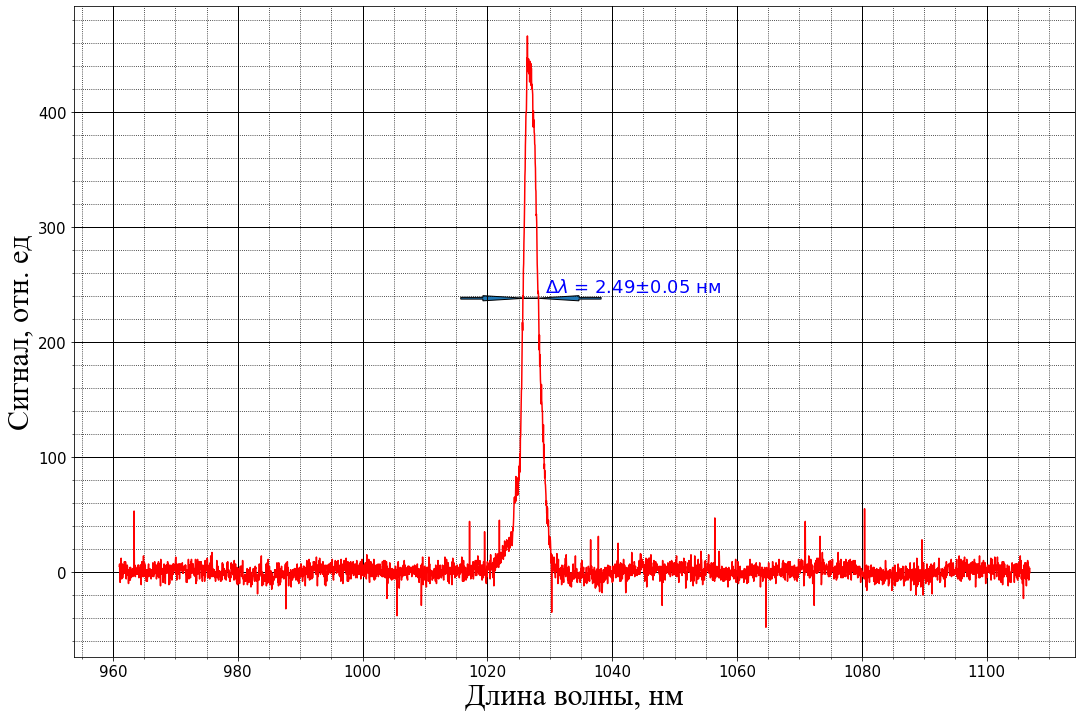

In [32]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(wavelenght, Signal_spectrum, c = 'r') 
ax.set_xlabel('Длина волны, нм',{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=30)
ax.set_ylabel("Сигнал, отн. ед",{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=30)
ax.arrow(wavelenght[1601]-10, Signal_spectrum[1601], 3.55, 0, width = 1.5 )
ax.arrow(wavelenght[1663]+10, Signal_spectrum[1601], -3.55, 0, width = 1.5 )
ax.arrow(wavelenght[1663], Signal_spectrum[1601], -3, 0)
plt.annotate('$\Delta{\lambda}$ = 2.49$\pm$0.05 нм', xy = (wavelenght[1663] +1, Signal_spectrum[1601]+5), fontsize = 18,color = 'b' )
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=15)
ax.minorticks_on()

#  Определяем внешний вид линий основной сетки:
ax.grid(which='major',
        color = 'k', 
        linewidth = 1)

#  Определяем внешний вид линий вспомогательной
#  сетки:
ax.grid(which='minor', 
        color = 'k', 
        linestyle = ':')

In [33]:
for i in range(len(Signal_spectrum)): # Ручным способом нашел индексы отвечающие высоте 0.5*max, это оказались индексы [1601,1663]
    if Signal_spectrum.max()/2 - 8 <= Signal_spectrum[i] <= Signal_spectrum.max()/2 + 8 :
        print(i) # вывожу индексы длин волн удовлетворяющие условию полувысоты, извините за прямолинейность, np.where пощему-то не работало...

1600
1601
1663


In [34]:
wavelenght_main = wavelenght[np.where(Signal_spectrum == Signal_spectrum.max())] #длина волны, отвечающая пику импульса 
wavelenght_main

array([1026.41])

In [35]:
Delta_wavelenght_main = wavelenght[1663] - wavelenght[1601] # ширина импульса на полувысоте
Delta_wavelenght_main 

2.490000000000009

Посчитаем погрешности для длин волн, они будут исходить из погрешности спектрометра по оси абсцисс(длина волны), деление 0.04 nm и из погрешности спектрометра по оси ординат( выбор уровня 0.5 от высоты)

In [36]:
delta_ordinate = 1/(Signal_spectrum.max()/2)*100 # погрешность ось ординат
delta_ordinate

0.4291845493562232

In [37]:
delta_abscissa = 0.04/Delta_wavelenght_main*100 # погрешность ось абсцисс
delta_abscissa

1.6064257028112392

In [38]:
delta_Delta_wavelenght_main = np.sqrt(delta_ordinate**2 + delta_abscissa**2)
delta_Delta_wavelenght_main 

1.66276965213426

$\lambda_{0}$ = 1026 $\pm$ 21 nm

$\Delta{\lambda}$ = 2.49$\pm$0.05 nm

$\delta{\Delta{\lambda}}$ = 2%

In [39]:
frequency_main, delta_frequency = c/wavelenght_main, c*(1/(wavelenght_main - Delta_wavelenght_main/2) - 1/(wavelenght_main + Delta_wavelenght_main/2))
Delta_delta_frequency = delta_frequency*delta_Delta_wavelenght_main/100
frequency_main, delta_frequency, Delta_delta_frequency

(array([292280.8624234]), array([709.05429429]), array([11.78993962]))

$\nu_{0}$ = (292 $\pm$ 6) ТГц

$\Delta{\nu}$ = 709$\pm$12 ГГц

$\delta{\Delta{\nu}}$ = 2%

## Четвертое задание
### Привести среднюю мощность на выходе из лазера и кристалла, определить эффективность преобразования во 2 гармонику 

In [40]:
P_list_before = [104.4, 104.3, 102.9, 101.1, 103.1, 103.2]
P_list_after = [33.19, 31.55, 33.53, 34.76, 34.19, 34.31]
P_list_before_errors = rand_error(P_list_before, 0.66)
P_list_after_errors = rand_error(P_list_after, 0.66)
P_first_harmonic, Delta_P_first_harmonic, delta_P_first_harmonic = P_list_before_errors[0], P_list_before_errors[1], P_list_before_errors[1]/P_list_before_errors[0]*100
print(P_first_harmonic, Delta_P_first_harmonic, delta_P_first_harmonic)
P_second_harmonic, Delta_P_second_harmonic, delta_P_second_harmonic = P_list_after_errors[0], P_list_after_errors[1], P_list_after_errors[1]/P_list_after_errors[0]*100
print(P_second_harmonic, Delta_P_second_harmonic, delta_P_second_harmonic)
conversion_efficiency = P_second_harmonic/P_first_harmonic*100
delta_conversion_efficiency = np.sqrt(delta_P_first_harmonic**2 + delta_P_second_harmonic**2)
Delta_conversion_efficiency = conversion_efficiency*delta_conversion_efficiency/100
print(conversion_efficiency, Delta_conversion_efficiency, delta_conversion_efficiency)

103.16666666666669 0.46805003293807623 0.4536833921855343
33.58833333333333 0.4486449621731344 1.3357166541154204
32.5573505654281 0.4592742098122797 1.410662114195411


$P_{1}~=~103.2\pm0.5~~мВт~~\delta{P_{1}} = 0.5$%

$P_{2}~=~33.6\pm0.5~~мВт~~\delta{P_{1}} = 1.3$%

$Ef~=~32.6\pm0.5$%$~~\delta{P_{1}} = 1.4$%

# Шестое-Седьмое-Восьмое задание
## Оценить энергию в одном импульсе
Так как мы измерили период следования импульса $Т_{pulse}$ = (4992$\pm$3)*10^-7 c, Среднюю мозщность импульса $P_{1}~=~103.2\pm0.5~~мВт$, а также "измерили" длительность импульса с помощью автокоррелятора $t_{pulse}~=~288.4\pm20.9~~фс$

In [41]:
t_pulse = 288.4*10**-15
Delta_t_pulse = 20.9*10**-15
delta_t_pulse = Delta_t_pulse/t_pulse*100

In [42]:
E_pulse = mean_interval_period*P_first_harmonic/1000
Delta_E_pulse = mean_interval_period*Delta_P_first_harmonic + P_first_harmonic*round_func([Delta_mean_interval_period])[0] #расчет погрешности косвенной величены
delta_E_pulse = Delta_E_pulse/E_pulse*100
print(E_pulse, Delta_E_pulse, delta_E_pulse)

5.149605433333335e-05 0.0002645790461411725 513.7850842485047


$E_{pulse}~=~51.5\pm0.3~мкДж~~~~~\delta{E_{pulse}}~=~0.5$%

## Оценить пиковую мощность
Имея энергию в одном импульсе и, зная его длительность, нетрудно сосчитать пиковую мощность импульса, как отношение этих величин 

In [43]:
P_peak = E_pulse/t_pulse
Delta_P_peak = Delta_E_pulse/t_pulse +  E_pulse/t_pulse*delta_t_pulse/100 #расчет погрешности косвенной величены
delta_P_peak = Delta_P_peak/P_peak*100
print(P_peak/10**9, Delta_P_peak/10**9, delta_P_peak)

0.17855774734165514 0.9303429371033741 521.0319635827628


$P_{peak}~=~180\pm14~~МВт~~~~\delta{P_{peak}}~=~8$%

## Оценить пиковую интенсивность
Имеется пиковая мощность и диаметр пучка. Пиковую интенсивность будем искать в виде отношения мощности импульса на площадь поперечного сечения пучка

In [44]:
d_beam = 8*10**-6

In [45]:
I_peak = P_peak*4/(3.14*d_beam**2)
Delta_I_peak = I_peak*delta_P_peak/100
delta_I_peak = delta_P_peak
print(I_peak, Delta_I_peak, delta_I_peak)

3.5540952894437724e+18 1.8517972474191364e+19 521.0319635827628


$I_{peak}~=~(36\pm3)*10^{17}~~Вт/м^2~~~~\delta{I_{peak}}~=~8$%

## Оценить является ли импульс спектрально ограниченным 
Рассмотрим величины такие, как спетральную ширину импульса $\Delta{\nu}$ = 709$\pm$14 ГГц и длительность импульса $t_{pulse}~=~288.4\pm20.9~~фс$. Они связаны через коэффициент квадрата гиперболического секанса (sech2), что соответствует величине k=0,315. Проверим насколько наши значения далеки от теоретических сведений.

In [46]:

k = t_pulse*delta_frequency*10**9
Delta_k = Delta_t_pulse*delta_frequency*10**9 + t_pulse*Delta_delta_frequency*10**9
delta_k = Delta_k/k*100
print(k, Delta_k, delta_k )

[0.20449126] [0.01821945] [8.90964899]


$k = 0.205\pm0.018~~~~~\delta{k}~=~9$%  $k_{табличное} = 0.315$ -- не совпадает, с теоретическим значением, так как наши измерения не являются истинными из-за устарелой аппаратуры, которая мериет хуёво, а еще и пирнцип измереняия хуёвый, а еще у нас руки кривые....